In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime as dt

import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
df = pd.read_csv('/content/drive/MyDrive/test/MSN.csv', parse_dates=['Date/Time']) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Ticker         135354 non-null  object        
 1   Date/Time      135354 non-null  datetime64[ns]
 2   Open           135354 non-null  float64       
 3   High           135354 non-null  float64       
 4   Low            135354 non-null  float64       
 5   Close          135354 non-null  float64       
 6   Volume         135354 non-null  int64         
 7   Open Interest  135354 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 8.3+ MB


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))
print(scaled_data.shape)

(135354, 1)


In [5]:
predcition_step = 114  

len_train = int(len(scaled_data) * 0.8) 

x_train = [] 
y_train = [] 

for i in range(predcition_step, len_train) :  
    x_train.append(scaled_data[i-predcition_step : i, 0]) 
    y_train.append(scaled_data[i, 0])  

x_train, y_train = np.array(x_train), np.array(y_train)  
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 

print(x_train.shape, y_train.shape)

(108169, 114, 1) (108169,)


In [61]:
len_val = int(len(scaled_data) - len_train)
x_val = [] 
y_val = [] 

for i in range(len_train , len(scaled_data)) : 
    x_val.append(scaled_data[i-predcition_step: i, 0]) 
    y_val.append(scaled_data[i, 0])

x_val, y_val = np.array(x_val), np.array(y_val) 
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1],1)) 
y_val = scaler.inverse_transform(y_val.reshape(-1,1))
print(x_val.shape, y_val.shape) 


(27071, 114, 1) (27071, 1)


In [77]:
def LinearRegression() : 
  model = Sequential() 
  model.add(tf.keras.layers.Flatten(input_shape = (x_train.shape[1], 1))) 
  model.add(Dense(100, activation = 'sigmoid')) 
  model.add(Dense(50, activation = 'sigmoid')) 
  model.add(Dense(50, activation = 'sigmoid')) 
  model.add(Dense(25, activation = 'sigmoid')) 
  model.add(Dense(1))
  return model 

In [79]:
modelLinear = LinearRegression() 
modelLinear.summary() 
modelLinear.compile(loss = 'mse', optimizer = 'adam') 

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 114)               0         
                                                                 
 dense_35 (Dense)            (None, 100)               11500     
                                                                 
 dense_36 (Dense)            (None, 50)                5050      
                                                                 
 dense_37 (Dense)            (None, 50)                2550      
                                                                 
 dense_38 (Dense)            (None, 25)                1275      
                                                                 
 dense_39 (Dense)            (None, 1)                 26        
                                                                 
Total params: 20,401
Trainable params: 20,401
Non-tra

In [80]:
checkpointer = ModelCheckpoint(filepath = 'bestLinear.h5', 
                               verbose = 2, 
                               save_best_only = True)

historyLinear = modelLinear.fit(x_train, 
          y_train, 
          epochs=10, 
          batch_size = 32,
          validation_data = (x_val, y_val), 
          callbacks = [checkpointer])

Epoch 1/10
3378/3381 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 1: val_loss improved from inf to 4527.30518, saving model to bestLinear.h5
3381/3381 [==============================] - 16s 4ms/step - loss: 0.0014 - val_loss: 4527.3052
Epoch 2/10
3372/3381 [============================>.] - ETA: 0s - loss: 5.4975e-05
Epoch 2: val_loss did not improve from 4527.30518
3381/3381 [==============================] - 13s 4ms/step - loss: 5.5003e-05 - val_loss: 4528.6719
Epoch 3/10
3373/3381 [============================>.] - ETA: 0s - loss: 4.7421e-05
Epoch 3: val_loss did not improve from 4527.30518
3381/3381 [==============================] - 14s 4ms/step - loss: 4.7362e-05 - val_loss: 4527.9595
Epoch 4/10
3379/3381 [============================>.] - ETA: 0s - loss: 4.2456e-05
Epoch 4: val_loss did not improve from 4527.30518
3381/3381 [==============================] - 13s 4ms/step - loss: 4.2462e-05 - val_loss: 4527.3760
Epoch 5/10
3371/3381 [===========================

In [81]:
model.save('modelLinear.h5')

In [83]:
predicted_prices = modelLinear.predict(x_val)
print(predicted_prices.shape) 
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices


846/846 [==============================] - 1s 2ms/step
(27071, 1)


array([[57.67498 ],
       [57.666042],
       [57.65752 ],
       ...,
       [82.207985],
       [82.21267 ],
       [82.21838 ]], dtype=float32)

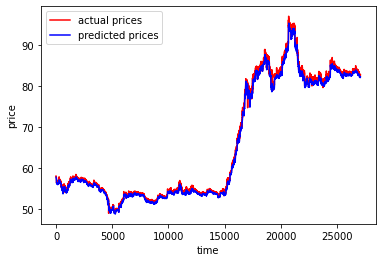

In [84]:
plt.plot(y_val, color = 'red', label = 'actual prices')
plt.plot(predicted_prices, color = 'blue', label = 'predicted prices') 
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()

In [7]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model


In [8]:
model = LSTM_model() 
model.summary() 
model.compile(loss = 'mse', optimizer = 'adam') 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 114, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 114, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 114, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 114, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [9]:
checkpointer = ModelCheckpoint(filepath = 'bestLSTM.h5', 
                               verbose = 2, 
                               save_best_only = True)

history = model.fit(x_train, 
          y_train, 
          epochs=10, 
          batch_size = 32,
          validation_data = (x_val, y_val), 
          callbacks = [checkpointer])

Epoch 1/10
3379/3381 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 1: val_loss improved from inf to 0.00004, saving model to best.hdf5
3381/3381 [==============================] - 74s 19ms/step - loss: 0.0013 - val_loss: 4.2400e-05
Epoch 2/10
3379/3381 [============================>.] - ETA: 0s - loss: 3.9295e-04
Epoch 2: val_loss did not improve from 0.00004
3381/3381 [==============================] - 55s 16ms/step - loss: 3.9300e-04 - val_loss: 5.9125e-05
Epoch 3/10
3379/3381 [============================>.] - ETA: 0s - loss: 3.5877e-04
Epoch 3: val_loss did not improve from 0.00004
3381/3381 [==============================] - 54s 16ms/step - loss: 3.5881e-04 - val_loss: 5.3765e-05
Epoch 4/10
3379/3381 [============================>.] - ETA: 0s - loss: 3.4607e-04
Epoch 4: val_loss improved from 0.00004 to 0.00003, saving model to best.hdf5
3381/3381 [==============================] - 54s 16ms/step - loss: 3.4608e-04 - val_loss: 3.3258e-05
Epoch 5/10
3380/3381 [====

In [11]:
model.save('modelLSTM.h5')

In [10]:
predicted_prices = model.predict(x_val)
predicted_prices = scaler.inverse_transform(predicted_prices)

(27071, 114, 1)
846/846 [==============================] - 7s 7ms/step
(27071, 1)


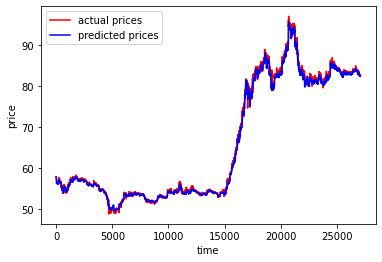

In [24]:
plt.plot(y_val, color = 'red', label = 'actual prices')
plt.plot(predicted_prices, color = 'blue', label = 'predicted prices') 
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()

In [34]:
# du doan gia cua ngay sau, phut dau tien mo cua cua ngay sau 
input_data = scaled_data[len(scaled_data) - predcition_step :len(scaled_data) + 1] 
input_data = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))

In [53]:
output = model.predict(input_data)
output = scaler.inverse_transform(output) 
print("Gia co phieu hien tai", y_val[-1][0])
print("Du doan gia co phieu phut sau : ", output[0][0])
print("Bien dong gia co phieu : ", (output - y_val[-1])[0][0])

1/1 [==============================] - 0s 23ms/step
Gia co phieu hien tai 82.8
Du doan gia co phieu phut sau :  82.54525
Bien dong gia co phieu :  -0.2547500610351534
